In [1]:
import pandas as pd
import numpy as np

In [2]:
co = pd.read_csv('co_agco_new.csv', sep = '|', low_memory=False)

In [3]:
cd = pd.read_csv('cd_agco_new.csv', sep = '|', low_memory=False)

In [4]:
cod = pd.merge(co, cd, on='co_id', how='inner')

In [7]:
#codlocations = cod['supply_location_id'].unique()

In [5]:
locations = pd.read_csv('locations_agco_new.csv', sep='|', low_memory=False)

In [6]:
cod_loc = pd.merge(cod, locations, left_on='supply_location_id', right_on='location_id', how='left')

In [21]:
#cod_loc_no_dealer = cod_loc[pd.isnull(cod_loc['group1'])]

In [22]:
#locations_no_dealer = cod_loc_no_dealer['supply_location_id'].unique()

In [19]:
#dealer = cod_loc['group1'].unique()

In [23]:
#dealer_from_loc = locations['group1'].unique()

In [7]:
dealer_items = cod_loc[['group1', 'item_id', 'requested_quantity']]

In [33]:
user_item = dealer_items.groupby(by=['group1', 'item_id']).sum().reset_index()

In [34]:
user_item.columns = ['user', 'item', 'purchases']

In [35]:
user_item = user_item.loc[user_item.purchases > 0]
user_item['purchases'] = np.clip(user_item.purchases, a_min=1, a_max=np.percentile(user_item.purchases, 90))
user_item['user'] = pd.Categorical(user_item.user).codes
user_item['item'] = pd.Categorical(user_item.item).codes
user_item.head()

,user,item,purchases
0,0,46,1.0
1,0,47,1.0
2,0,120,4.0
3,0,956,4.0
4,0,1373,1.0


In [36]:
from scipy.sparse import coo_matrix, csr_matrix
user_item_coo = coo_matrix((user_item.purchases, (user_item.user, user_item.item)))
user_item_coo

<284x283284 sparse matrix of type '<class 'numpy.float64'>'
	with 2139370 stored elements in COOrdinate format>

In [37]:
user_item_csr = user_item_coo.tocsr()

In [4]:
def avg_items(csr):
    user = np.unique(csr.tocoo().row)
    num_items = []
    for u in user :
        num_items.append(len(csr[u].data))
    return pd.Series(num_items)

<AxesSubplot:>

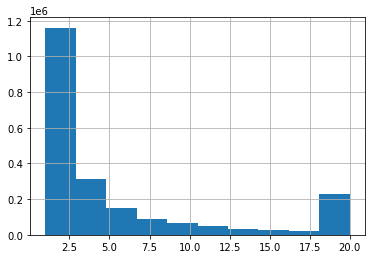

In [38]:
pd.Series(user_item_csr.data).hist()

In [42]:
user_item_csr.nnz / (user_item_csr.shape[0] * user_item_csr.shape[1])

0.026591664046492137

In [43]:
1 - (user_item_csr.nnz / (user_item_csr.shape[0] * user_item_csr.shape[1]))

0.9734083359535078

In [45]:
from implicit.evaluation import train_test_split, ranking_metrics_at_k
from implicit.als import AlternatingLeastSquares

In [46]:
train, test = train_test_split(user_item_csr)

In [51]:
model = AlternatingLeastSquares(factors=64, regularization=30, use_native=True, use_cg=True)

In [52]:
model.fit(train * 0.4)

100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


In [53]:
metrics = ranking_metrics_at_k(model, train, test, K=10)
metrics

100%|██████████| 284/284 [00:00<00:00, 687.69it/s]


{'precision': 0.8028169014084507,
 'map': 0.7261063603845296,
 'ndcg': 0.8184837226990112,
 'auc': 0.5060009908717277}

In [33]:
test_filter = dealer_items[(dealer_items['item_id'] == '001051620') & (dealer_items['group1'] == 'ACA')]

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession

In [2]:
import findspark
findspark.init()

In [3]:
spark = SparkSession.builder.getOrCreate()

RuntimeError: Java gateway process exited before sending its port number

In [16]:
ratings = spark.createDataFrame(user_item)

NameError: name 'spark' is not defined